In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

import pydot as pyd
from tensorflow.keras.utils import plot_model, model_to_dot
import tensorflow
tensorflow.keras.utils.pydot = pyd

# Read Data

In [2]:
data = pkl.load(open('data.pkl', 'rb'))

X_input_train = data['X_input_train']
X_output_train = data['X_output_train']
X_input_test = data['X_input_test']
X_output_test = data['X_output_test']

x1_trend_param = data['x1_trend_param']
x2_trend_param = data['x2_trend_param']
x_train_max = data['x_train_max']

# Model
![Image of Luong Attention](https://github.com/HuangWeiKulish/Forecasting/blob/master/seq2seq.png?raw=true)

In [3]:
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))
n_hidden = 100
print(input_train)
print(output_train)

KerasTensor(type_spec=TensorSpec(shape=(None, 200, 2), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 2), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


#### What to Return using LSTM
- __*return_sequences=False, return_state=False*__: the last hidden state: state_h
- __*return_sequences=True, return_state=False*__: return stacked hidden states (num_timesteps * num_cells): one hidden state output for each input time step
- __*return_sequences=False, return_state=True*__: generate 3 arrays: state_h, state_h, state_c
- __*return_sequences=True, return_state=True*__: generate 3 arrays: stacked hidden states, last state_h, last state_c

In [4]:
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
    return_sequences=False, return_state=True)(input_train)
print(encoder_last_h1)
print(encoder_last_h2)
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/strided_slice_3:0', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/while:4', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/while:5', description="created by layer 'lstm'")


In [5]:
encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1) 
print(encoder_last_h1)

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='batch_normalization/batchnorm/add_1:0', description="created by layer 'batch_normalization'")


In [6]:
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c) 
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='batch_normalization_1/batchnorm/add_1:0', description="created by layer 'batch_normalization_1'")


In [7]:
decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)
print(decoder)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='repeat_vector/Tile:0', description="created by layer 'repeat_vector'")


In [8]:
decoder = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
               return_state=False, return_sequences=True)(
    decoder, initial_state=[encoder_last_h1, encoder_last_c])
print(decoder)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='lstm_1/transpose_1:0', description="created by layer 'lstm_1'")


In [9]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 2), dtype=tf.float32, name=None), name='time_distributed/Reshape_1:0', description="created by layer 'time_distributed'")


In [10]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 2)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100), (None, 41200       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100)          400         lstm[0][0]                       
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 20, 100)      0           batch_normalization[0][0]        
______________________________________________________________________________________________

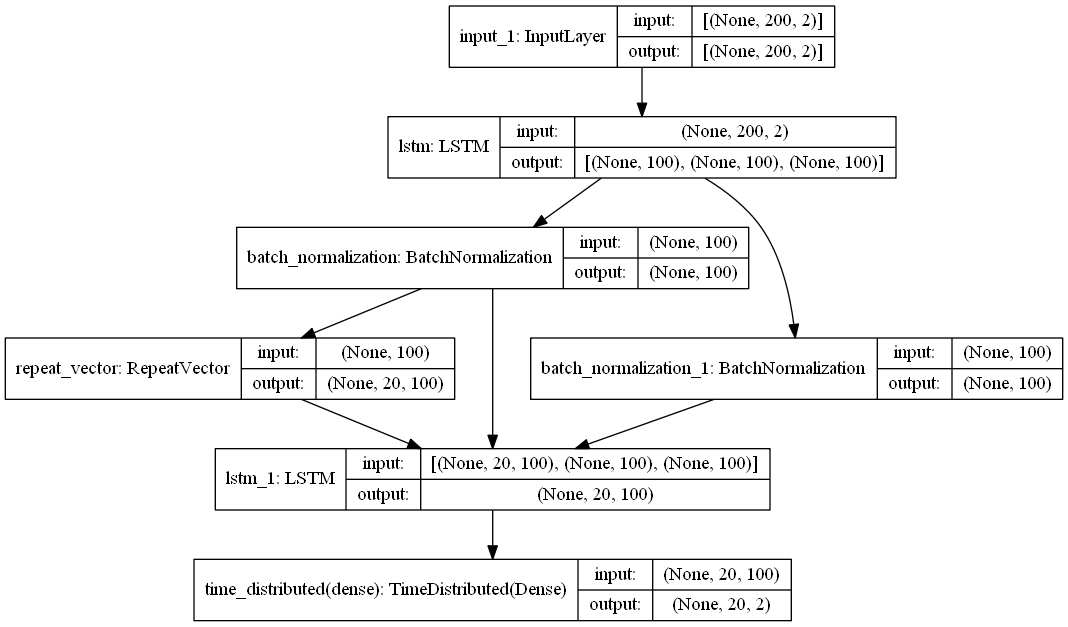

In [11]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [12]:
epc = 100
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train[:, :, :2], X_output_train[:, :, :2], validation_split=0.2, 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
 
model.save('save/model_forecasting_seq2seq.h5')

Epoch 1/100
5/5 [==============================] - 6s 573ms/step - loss: 4.8826 - mae: 1.1090 - val_loss: 0.1408 - val_mae: 0.2760
Epoch 2/100
5/5 [==============================] - 1s 258ms/step - loss: 0.2908 - mae: 0.3852 - val_loss: 0.1519 - val_mae: 0.2866
Epoch 3/100
5/5 [==============================] - 2s 329ms/step - loss: 0.1460 - mae: 0.2838 - val_loss: 0.1257 - val_mae: 0.2601
Epoch 4/100
5/5 [==============================] - 2s 350ms/step - loss: 0.1330 - mae: 0.2673 - val_loss: 0.1168 - val_mae: 0.2521
Epoch 5/100
5/5 [==============================] - 2s 356ms/step - loss: 0.1309 - mae: 0.2666 - val_loss: 0.1154 - val_mae: 0.2506
Epoch 6/100
5/5 [==============================] - 2s 364ms/step - loss: 0.1247 - mae: 0.2591 - val_loss: 0.1129 - val_mae: 0.2496
Epoch 7/100
5/5 [==============================] - 2s 370ms/step - loss: 0.1236 - mae: 0.2591 - val_loss: 0.1040 - val_mae: 0.2412
Epoch 8/100
5/5 [==============================] - 2s 418ms/step - loss: 0.1126 - m

KeyboardInterrupt: 

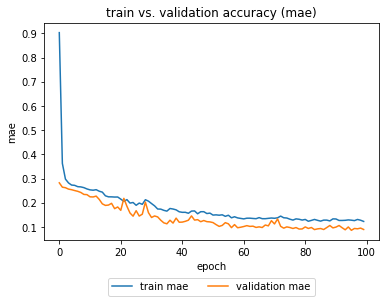

In [13]:
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

# Predict

In [14]:
train_pred_detrend = model.predict(X_input_train[:, :, :2])*x_train_max[:2]
test_pred_detrend = model.predict(X_input_test[:, :, :2])*x_train_max[:2]
print(train_pred_detrend.shape, test_pred_detrend.shape)

train_true_detrend = X_output_train[:, :, :2]*x_train_max[:2]
test_true_detrend = X_output_test[:, :, :2]*x_train_max[:2]
print(train_true_detrend.shape, test_true_detrend.shape)

(600, 20, 2) (181, 20, 2)
(600, 20, 2) (181, 20, 2)


In [15]:
# combine with the index
train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

(600, 20, 3) (181, 20, 3)
(600, 20, 3) (181, 20, 3)


In [16]:
# recover trend
data_final = dict()

for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt[:, :, 0] + (dt[:, :, 2]**2)*x1_trend_param[0] + dt[:, :, 2]*x1_trend_param[1] + x1_trend_param[2]
    dt_x2 = dt[:, :, 1] + dt[:, :, 2]*x2_trend_param[0] + x2_trend_param[1]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)], axis=2)
    print(lb+': {}'.format(data_final[lb].shape))


train_pred: (600, 20, 2)
train_true: (600, 20, 2)
test_pred: (181, 20, 2)
test_true: (181, 20, 2)


In [17]:
for k in ['train_pred', 'train_true', 'test_pred', 'test_true']:
    print('maximum: {}'.format(k))
    print(data_final[k].max())

maximum: train_pred
225.4286567468289
maximum: train_true
224.61373469126457
maximum: test_pred
310.51208906321364
maximum: test_true
307.0617184410105


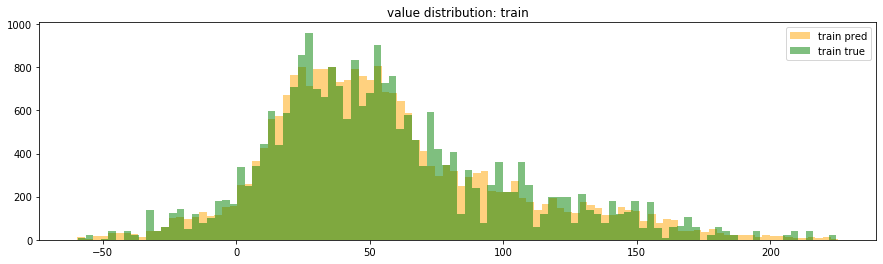

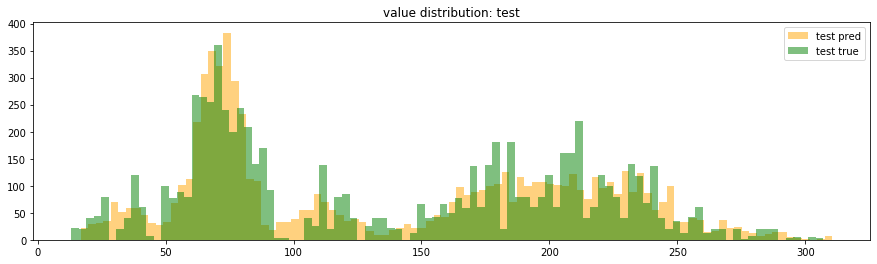

In [18]:
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.5, label=lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

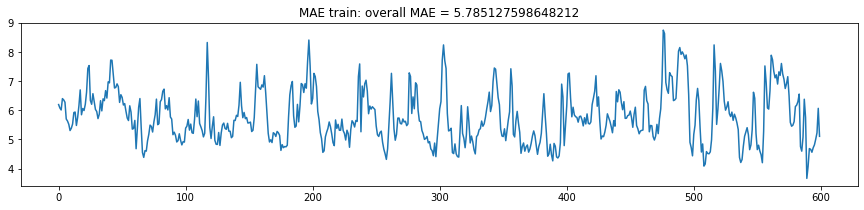

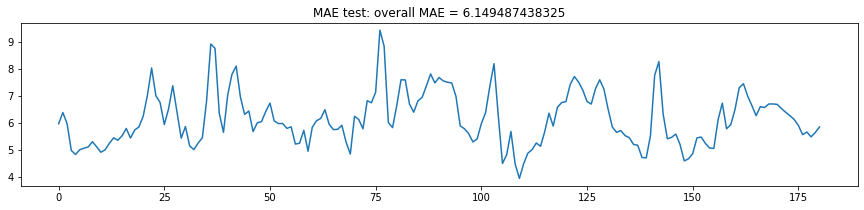

In [19]:
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show() 

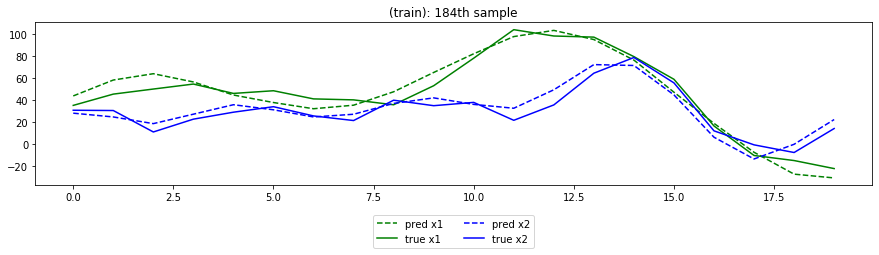

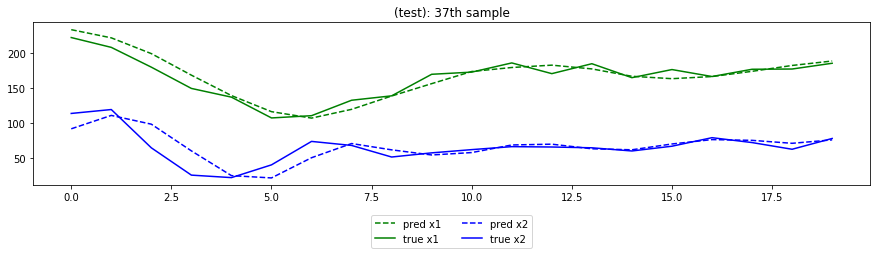

In [21]:
for lb in ['train', 'test']:
    ith_sample = random.choice(range(data_final[lb+'_pred'].shape[0]))

    plt.figure(figsize=(15,3))
    for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
        plt.plot(data_final[lb+'_pred'][ith_sample, :, i], linestyle='--', color=clr, label='pred '+x_lbl)
        plt.plot(data_final[lb+'_true'][ith_sample, :, i], linestyle='-', color=clr, label='true '+x_lbl)
    plt.title('({}): {}th sample'.format(lb, ith_sample))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
    plt.show()

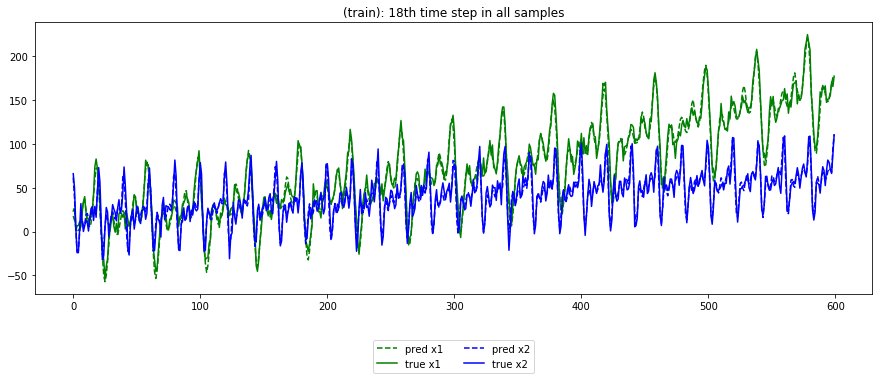

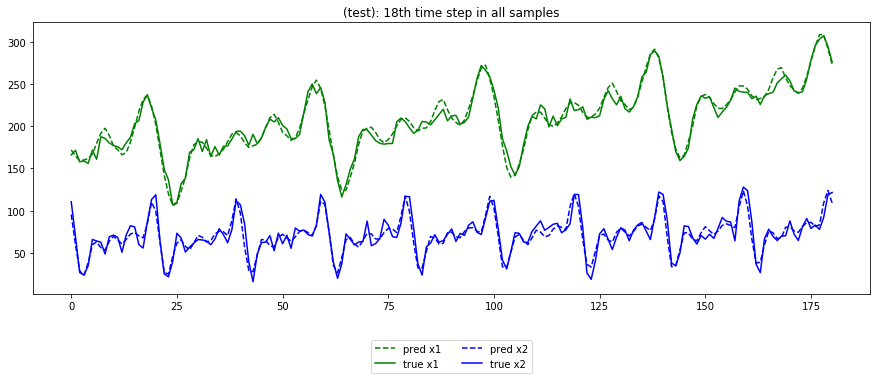

In [46]:
ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
for lb in ['train', 'test']:   
    plt.figure(figsize=(15, 5))
    for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
        plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
        plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
    plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
    plt.show()


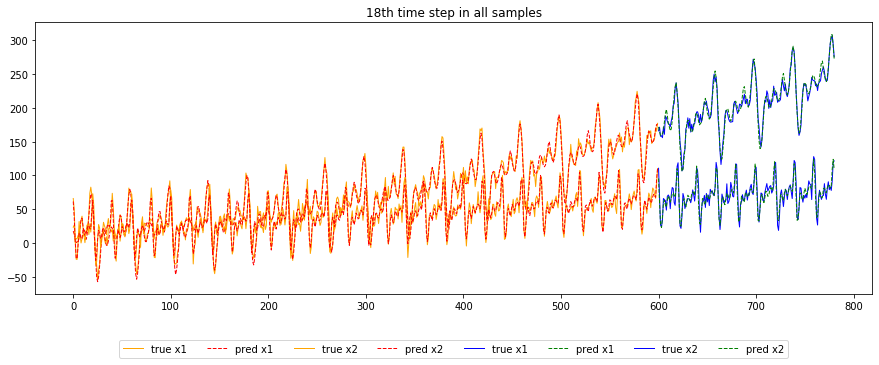

In [57]:
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0, 1], ['x1', 'x2']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
    
plt.title('{}th time step in all samples'.format(lb, ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()